## Script to create release locations of plastic from fishing activity
We use the Global Fishing Watch v2 Dataset found here: https://globalfishingwatch.org/data-download/datasets/public-fishing-effort

We first download the 'fleet-daily-csv-100-v2-YYYY.zip' files, and store them in the folder 'data/release/GlobalFishingWatch/'

We then run this script to create a .csv file with location, month, and summed fishing hours data.

In [17]:
import pandas as pd
import glob
import cartopy.io.shapereader as shpreader
import xarray as xr
import numpy as np
from scipy import spatial


In [2]:
input_data = '../../data/release/GlobalFishingWatch/'
output_data = '../../data/release/generated_files/'

In [3]:
files_fisheries = sorted(glob.glob(input_data+'fleet*/*') )

In [4]:
# New approach to storing the data - just store as lat/lon/month-year/sum(fishing_hours) - this is model independent!
data_fisheries = []
for file_ in files_fisheries:
    data_fisheries_day = pd.read_csv(file_)
    data_fisheries_day = data_fisheries_day[data_fisheries_day['fishing_hours'] > 0]
    data_fisheries.append(data_fisheries_day)

data_fisheries = pd.concat(data_fisheries, axis=0, ignore_index=True)

In [5]:
## Aggregate by location, flag, geartype, and date
agg_data_fisheries = data_fisheries.groupby(['cell_ll_lat', 'cell_ll_lon', 'flag', 'geartype', 'date'])['fishing_hours'].agg('sum').reset_index()

In [6]:
## Aggregate by location, flag, geartype, and month
agg_data_fisheries['date'] = pd.to_datetime(agg_data_fisheries['date'])
agg_data_fisheries['month'] = agg_data_fisheries['date'].values.astype('datetime64[M]')
agg_data_fisheries = agg_data_fisheries.groupby(['cell_ll_lat', 'cell_ll_lon', 'flag', 'geartype', 'month'])['fishing_hours'].agg('sum').reset_index()

In [7]:
# Store datafile
agg_data_fisheries.to_csv(output_data+'fleet_monthly_aggregated.csv')
## This chops it down from 70gb for one year to 2gb!

In [8]:
agg_data_fisheries

,cell_ll_lat,cell_ll_lon,flag,geartype,month,fishing_hours
0,-77.84,-177.56,NZL,set_longlines,2020-01-01,0.0336
1,-77.83,-177.66,NZL,set_longlines,2020-01-01,0.0830
2,-77.83,-177.65,NZL,set_longlines,2020-01-01,0.9102
3,-77.83,-177.57,NZL,set_longlines,2020-01-01,0.0836
4,-77.83,-177.56,NZL,set_longlines,2020-01-01,0.0652
...,...,...,...,...,...,...
54437360,81.69,35.01,EST,trawlers,2020-10-01,0.0333
54437361,81.69,35.03,EST,trawlers,2020-09-01,0.0175
54437362,81.69,35.03,EST,trawlers,2020-10-01,0.0188
54437363,81.70,34.70,EST,trawlers,2020-11-01,0.0499


In [9]:
## Match flag to country attributes
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

countries_list = []
for country in countries:
    continent = country.attributes['CONTINENT']
    region_un = country.attributes['REGION_UN']
    subregion = country.attributes['SUBREGION']
    country_name = country.attributes['NAME_LONG']
    country_flag = country.attributes['ISO_A3']

    # Where the Natural Earth dataset doesn't match the ISO standard (e.g. France), use the SU_A3 column
    if country_flag == '-99':
        country_flag = country.attributes['SU_A3']

    countries_list.append({'Continent': continent,
                            'Region': region_un,
                            'Subregion': subregion,
                            'Country': country_name,
                            'flag': country_flag})
countries_df = pd.DataFrame.from_records(countries_list)

In [10]:
# Combine datasets
agg_data_fisheries_info = pd.merge(agg_data_fisheries, countries_df, on="flag", how="left") #
agg_data_fisheries_info = agg_data_fisheries_info.rename(columns={"cell_ll_lat": "Latitude", "cell_ll_lon": "Longitude"})

In [11]:
# Store datafile
agg_data_fisheries_info.to_csv(output_data+'agg_data_fisheries_info.csv')
## This chops it down from 70gb for one year to 2gb!

In [12]:
agg_data_fisheries_info

,Latitude,Longitude,flag,geartype,month,fishing_hours,Continent,Region,Subregion,Country
0,-77.84,-177.56,NZL,set_longlines,2020-01-01,0.0336,Oceania,Oceania,Australia and New Zealand,New Zealand
1,-77.83,-177.66,NZL,set_longlines,2020-01-01,0.0830,Oceania,Oceania,Australia and New Zealand,New Zealand
2,-77.83,-177.65,NZL,set_longlines,2020-01-01,0.9102,Oceania,Oceania,Australia and New Zealand,New Zealand
3,-77.83,-177.57,NZL,set_longlines,2020-01-01,0.0836,Oceania,Oceania,Australia and New Zealand,New Zealand
4,-77.83,-177.56,NZL,set_longlines,2020-01-01,0.0652,Oceania,Oceania,Australia and New Zealand,New Zealand
...,...,...,...,...,...,...,...,...,...,...
54437360,81.69,35.01,EST,trawlers,2020-10-01,0.0333,Europe,Europe,Northern Europe,Estonia
54437361,81.69,35.03,EST,trawlers,2020-09-01,0.0175,Europe,Europe,Northern Europe,Estonia
54437362,81.69,35.03,EST,trawlers,2020-10-01,0.0188,Europe,Europe,Northern Europe,Estonia
54437363,81.70,34.70,EST,trawlers,2020-11-01,0.0499,Europe,Europe,Northern Europe,Estonia


In [63]:
## Map to the ocean model grid

# Load in land mask
data_mask_land = xr.open_dataset('../../data/output_data/masks/mask_land_NEMO0083.nc')

lats_ocean = data_mask_land['lat'].data[np.where(~data_mask_land['mask_land'])]
lons_ocean = data_mask_land['lon'].data[np.where(~data_mask_land['mask_land'])]

# A list of ocean points
ocean_points = np.array([lons_ocean, lats_ocean]).T

# Find closest ocean cell to the fisheries data
fishing_points = np.array(agg_data_fisheries_info[['Longitude', 'Latitude']])
distances_deg, indices = spatial.KDTree(ocean_points).query(fishing_points)

mapped_ocean_points = ocean_points[indices]

# Add these mapped points to the fisheries data as extra columns
agg_data_fisheries_info.insert(0, "ModelLongitude", mapped_ocean_points[:,0])
agg_data_fisheries_info.insert(1, "ModelLatitude", mapped_ocean_points[:,1])

# Create a data set where longitude and latitude are from the model
model_agg_data_fisheries_info = agg_data_fisheries_info.groupby(['ModelLongitude', 'ModelLatitude', 'flag', 'geartype', 'month', 'Continent', 'Region', 'Subregion', 'Country'])['fishing_hours'].agg('sum').reset_index()


In [87]:
agg_data_fisheries_info

,Latitude,ModelLongitude,ModelLatitude,Longitude,flag,geartype,month,fishing_hours,Continent,Region,Subregion,Country
0,-77.84,-177.583333,-76.991731,-177.56,NZL,set_longlines,2020-01-01,0.0336,Oceania,Oceania,Australia and New Zealand,New Zealand
1,-77.83,-177.666667,-76.991731,-177.66,NZL,set_longlines,2020-01-01,0.0830,Oceania,Oceania,Australia and New Zealand,New Zealand
2,-77.83,-177.666667,-76.991731,-177.65,NZL,set_longlines,2020-01-01,0.9102,Oceania,Oceania,Australia and New Zealand,New Zealand
3,-77.83,-177.583333,-76.991731,-177.57,NZL,set_longlines,2020-01-01,0.0836,Oceania,Oceania,Australia and New Zealand,New Zealand
4,-77.83,-177.583333,-76.991731,-177.56,NZL,set_longlines,2020-01-01,0.0652,Oceania,Oceania,Australia and New Zealand,New Zealand
...,...,...,...,...,...,...,...,...,...,...,...,...
54437360,81.69,35.017510,81.629295,35.01,EST,trawlers,2020-10-01,0.0333,Europe,Europe,Northern Europe,Estonia
54437361,81.69,35.077198,81.683519,35.03,EST,trawlers,2020-09-01,0.0175,Europe,Europe,Northern Europe,Estonia
54437362,81.69,35.077198,81.683519,35.03,EST,trawlers,2020-10-01,0.0188,Europe,Europe,Northern Europe,Estonia
54437363,81.70,34.699243,81.688866,34.70,EST,trawlers,2020-11-01,0.0499,Europe,Europe,Northern Europe,Estonia


In [86]:
model_agg_data_fisheries_info

,ModelLongitude,ModelLatitude,flag,geartype,month,Continent,Region,Subregion,Country,fishing_hours
0,-179.998299,53.902935,USA,pots_and_traps,2020-09-01,North America,Americas,Northern America,United States,0.1477
1,-179.998244,64.513663,CYP,trawlers,2020-08-01,Asia,Asia,Western Asia,Cyprus,0.5673
2,-179.998244,64.513663,KOR,trawlers,2020-10-01,Asia,Asia,Eastern Asia,Republic of Korea,0.9904
3,-179.998244,64.513663,RUS,fishing,2020-09-01,Europe,Europe,Eastern Europe,Russian Federation,4.9353
4,-179.998244,64.513663,RUS,purse_seines,2020-09-01,Europe,Europe,Eastern Europe,Russian Federation,2.6808
...,...,...,...,...,...,...,...,...,...,...
5975965,180.000000,18.818880,TWN,drifting_longlines,2020-12-01,Asia,Asia,Eastern Asia,Taiwan,4.8436
5975966,180.000000,19.370117,TWN,drifting_longlines,2020-12-01,Asia,Asia,Eastern Asia,Taiwan,1.2607
5975967,180.000000,19.684276,CHN,squid_jigger,2020-06-01,Asia,Asia,Eastern Asia,China,1.7861
5975968,180.000000,22.329116,TWN,drifting_longlines,2020-02-01,Asia,Asia,Eastern Asia,Taiwan,0.4816


In [78]:
mapped_ocean_points.shape

(54437365, 2)

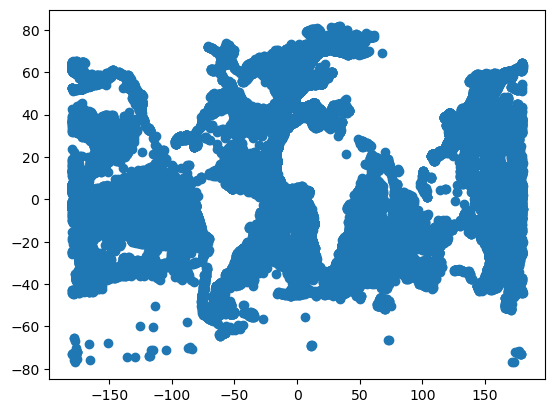

In [79]:
plt.scatter(mapped_ocean_points[::500,0], mapped_ocean_points[::500,1])
plt.show()

In [64]:
data_point = agg_data_fisheries_info.iloc[0]
distance, index = spatial.KDTree(ocean_points).query([data_point.Longitude, data_point.Latitude])

In [67]:
points = np.array([[data_point.Longitude, data_point.Latitude], [data_point.Longitude, data_point.Latitude], [data_point.Longitude, data_point.Latitude]])

In [70]:
distance

array([0.84858966, 0.84858966, 0.84858966])

In [45]:
data_point.Longitude

-177.56

In [54]:
data_mask_land.where(lon = data_point.Longitude, lat = data_point.Latitude)

type: DataWithCoords.where() got an unexpected keyword argument 'lon'

In [56]:
data_mask_land.where((data_mask_land.lon==0.5) & (data_mask_land.lat==0.5), drop=True)

<xarray.Dataset>
Dimensions:      (x: 0, y: 0)
Coordinates:
    lon          (x, y) float64 
    lat          (x, y) float64 
Dimensions without coordinates: x, y
Data variables:
    mask_land    (x, y) float64 
    explanation  (x, y) object

In [52]:
gpw = xr.open_dataset('/Users/denes001/Research/Projects/PlasticParcels/PlasticParcels/data/release/GPWv4/gpw-v4-population-density-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_rev11_2pt5_min.nc')

In [53]:
gpw

<xarray.Dataset>
Dimensions:                                                                    (
                                                                                longitude: 8640,
                                                                                latitude: 4320,
                                                                                raster: 20)
Coordinates:
  * longitude                                                                  (longitude) float64 ...
  * latitude                                                                   (latitude) float64 ...
  * raster                                                                     (raster) int32 ...
Data variables:
    Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes  (raster, latitude, longitude) float32 ...
Attributes:
    proj4:        +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0...
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 2.8-4)
    date:         2018-11-16 10:27:52